# Generacion modelo IA

En este notebook desarrollamos el modelo de detección de errores

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
import shutil

import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score,precision_score
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
from time import sleep

In [2]:
def get_jpg_paths(directory):
    """
    Recorre una carpeta y sus subcarpetas para encontrar archivos con extensión .jpeg.
    Retorna un DataFrame con una columna 'relative_path' que contiene los caminos relativos de las imágenes.
    
    Parameters:
        directory (str): El path a la carpeta raíz que contiene las subcarpetas.
    
    Returns:
        pd.DataFrame: Un DataFrame con los caminos relativos de las imágenes .jpeg.
    """
    jpg_paths = []
    
    # Recorre todas las carpetas y archivos dentro del directorio
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):  # Aseguramos que la extensión sea .jpeg
                # Calculamos el camino relativo
                relative_path = os.path.relpath(os.path.join(root, file), start=directory)
                jpg_paths.append(relative_path)
    
    # Creamos un DataFrame con los resultados
    df = pd.DataFrame(jpg_paths, columns=['relative_path'])
    return df

In [3]:
df_fallos=pd.read_csv('defectos_info.csv')
df_fallos

,relative_path,defecto
0,kos01\Part0.jpg,0
1,kos01\Part1.jpg,0
2,kos01\Part2.jpg,0
3,kos01\Part3.jpg,0
4,kos01\Part4.jpg,0
...,...,...
498,kos50\Part4_res.jpg,1
499,kos50\Part4_rot.jpg,1
500,kos50\Part5.jpg,0
501,kos50\Part6.jpg,0


In [4]:
df_fallos.value_counts('defecto')

defecto
0    347
1    156
Name: count, dtype: int64

In [5]:
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size
df_tama = df_fallos.copy()
# Añadir la columna de tamaño de imagen
df_tama['image_size'] = df_tama['relative_path'].apply(lambda x: get_image_size(os.path.join('data_augmentation', x)))

df_tama['image_size'].value_counts()

image_size
(500, 1260)    39
(500, 1253)    27
(500, 1254)    24
(500, 1261)    24
(500, 1259)    23
(500, 1270)    22
(500, 1263)    22
(500, 1255)    22
(500, 1257)    21
(500, 1267)    19
(500, 1256)    17
(500, 1264)    17
(500, 1251)    17
(500, 1266)    17
(500, 1258)    16
(500, 1265)    14
(500, 1250)    14
(500, 1247)    13
(500, 1262)    13
(500, 1252)    10
(500, 1248)    10
(500, 1249)     9
(500, 1274)     8
(500, 1246)     8
(500, 1244)     6
(500, 1241)     6
(500, 1269)     6
(500, 1281)     6
(500, 1273)     6
(500, 1245)     6
(500, 1271)     5
(500, 1240)     5
(500, 1268)     5
(500, 1282)     4
(500, 1243)     4
(500, 1280)     3
(500, 1272)     3
(500, 1242)     3
(500, 1275)     2
(500, 1235)     2
(500, 1284)     1
(500, 1276)     1
(500, 1285)     1
(500, 1277)     1
(500, 1239)     1
Name: count, dtype: int64

Al tener distintos tamaños, vamos a hacer un resize del tamaño que se nos marca como requerimiento inicial de 1408x512

In [6]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

Epoch 1/25, Train Loss: 1399.9801, Val Loss: 306.8999
Epoch 2/25, Train Loss: 512.6768, Val Loss: 75.2424
Epoch 3/25, Train Loss: 177.1568, Val Loss: 42.7319
Epoch 4/25, Train Loss: 77.5316, Val Loss: 24.9280
Epoch 5/25, Train Loss: 48.4195, Val Loss: 98.4479
Epoch 6/25, Train Loss: 21.4173, Val Loss: 11.7649
Epoch 7/25, Train Loss: 7.0271, Val Loss: 32.3911
Epoch 8/25, Train Loss: 3.5154, Val Loss: 20.5232
Epoch 9/25, Train Loss: 4.2742, Val Loss: 12.7399
Early stopping triggered


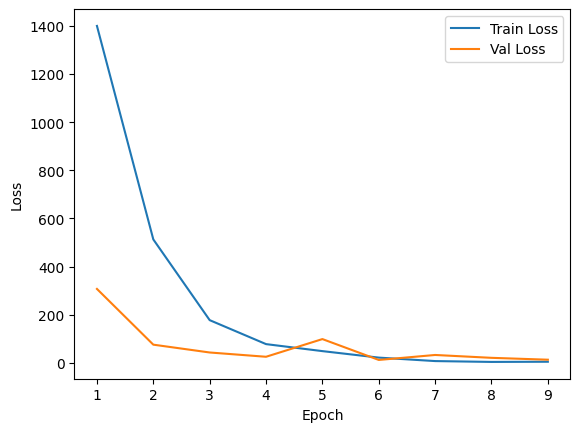

In [7]:

# Preparar los datos

# Filtrar las imágenes con defecto y sin defecto
df_defecto = df_fallos[df_fallos['defecto'] == 1]
df_no_defecto = df_fallos[df_fallos['defecto'] == 0]

# Seleccionar 120 imágenes de cada tipo para el conjunto de entrenamiento
df_defecto_train = df_defecto.sample(n=120, random_state=42)
df_no_defecto_train = df_no_defecto.sample(n=120, random_state=42)

# El resto de las imágenes se utilizarán para el conjunto de validación
df_defecto_val = df_defecto.drop(df_defecto_train.index)
df_no_defecto_val = df_no_defecto.drop(df_no_defecto_train.index)

# Combinar los conjuntos de entrenamiento y validación
df_train = pd.concat([df_defecto_train, df_no_defecto_train]).reset_index(drop=True)
df_val = pd.concat([df_defecto_val, df_no_defecto_val]).reset_index(drop=True)

# Definir el dataset personalizado
class DefectDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Definir las transformaciones
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Lo hago para distinguir los distintas escalas de gris
    transforms.ToTensor(),
    transforms.Resize((256,704)),
    transforms.Normalize((0.5,), (0.25,))
])

# Crear los datasets y dataloaders
train_dataset = DefectDataset(df_train, root_dir='data_augmentation', transform=transform)
val_dataset = DefectDataset(df_val, root_dir='data_augmentation', transform=transform)

# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear los dataloaders con num_workers
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Definir el modelo
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=705600, out_features=200)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(in_features=200, out_features=2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

# Inicializar el modelo, la función de pérdida y el optimizador
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)

# Entrenar el modelo con early stopping
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopper = EarlyStopper(patience=3, min_delta=0.001)

num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()  # Convert labels to one-hot encoding
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()  # Convert labels to one-hot encoding
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# Graficar las pérdidas
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
def visualize_true_vs_pred(y_pred,y_true,title=""):
    """
    y_pred,y_true: deben ser dos numpy arrays, que contengan las clases predichas y reales, respectivamente.
    title: un string que se añadirá en el título, para poder diferenciar la matriz de confusión del conjunto de entrenamiento y validación
    """
    
    prec = precision_score(y_true,y_pred,average="weighted")
    f1 = f1_score(y_true,y_pred,average="weighted")

    confusion_mat = confusion_matrix(y_true,y_pred)
    
    fig, ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
    disp.plot(ax=ax)
    Title = f"F1 Score = {round(f1,3)}, Precisión = {round(100*prec,2)}"
    if title: Title=title+": "+Title
    plt.title(Title)
    plt.show()

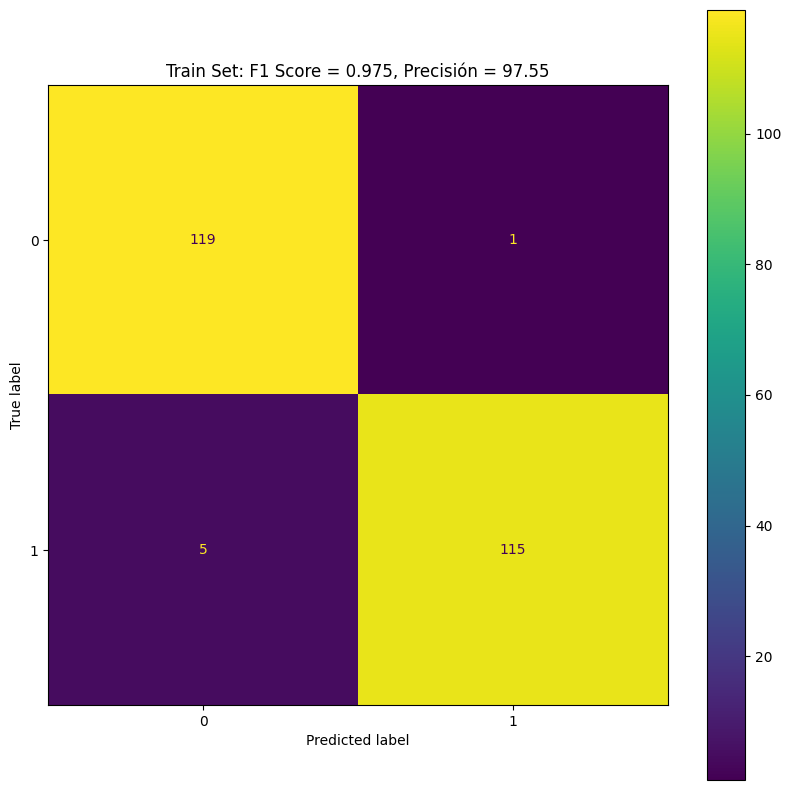

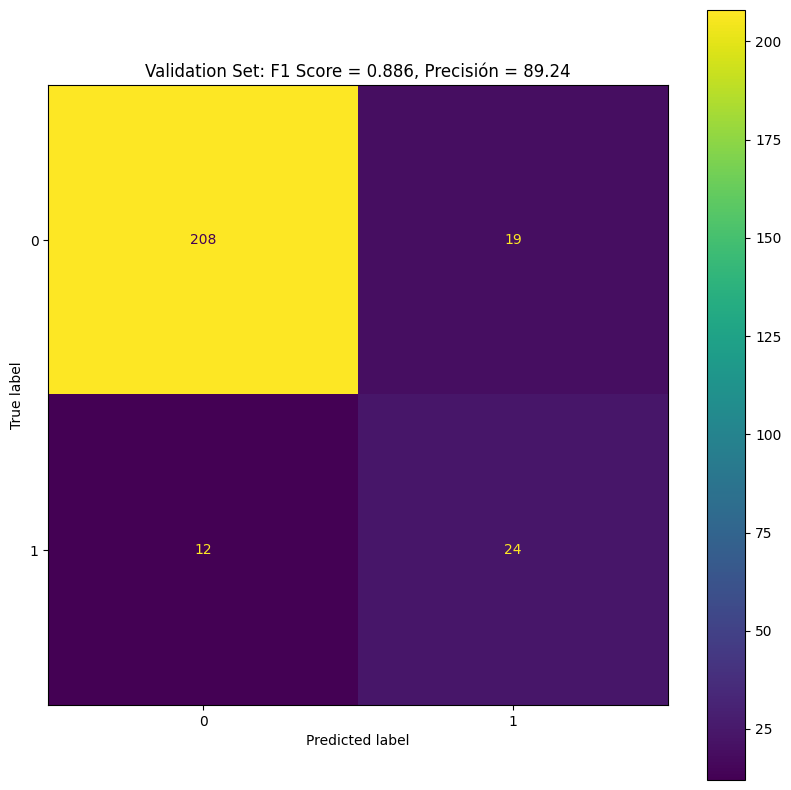

In [9]:
# Obtener predicciones para el conjunto de entrenamiento
model.eval()
train_preds = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Obtener predicciones para el conjunto de validación
val_preds = []
val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Visualizar la matriz de confusión para el conjunto de entrenamiento
visualize_true_vs_pred(np.array(train_preds), np.array(train_labels), title="Train Set")

# Visualizar la matriz de confusión para el conjunto de validación
visualize_true_vs_pred(np.array(val_preds), np.array(val_labels), title="Validation Set")

In [10]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'modelo_entrenado.pth')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.
